In [2]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
from Bio import SeqIO
import numpy as np # linear algebra
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [162]:
dna = pd.read_table('/content/input.txt')
dna.head()

# """
# Classe 0: DENV1
# Classe 1: DENV2
# Classe 2: SARS-CoV-2
# Classe 3: HPV 16
# Classe 4: HPV 18
# Classe 5: PFLUV 4
# Classe 6: PFLUV 2
# """

,sequence,class
0,cgacagaaatccagacgtcaggaacgacaacaatcttcgcaggaca...,0
1,cgacagaaatccagacgtcaggaacgacaacaatcttcgcaggaca...,0
2,cgacagaaatccagacgtcaggaacgacaacaatcttcgcaggaca...,0
3,cgacagaaatccagacgtcaggaacgacaacaatcttcgcaggaca...,0
4,cgacagaaatccagacgtcaggaacgacaacaatcttcgcaggaca...,0


Text(0.5, 1.0, 'Class distribution of DNA')

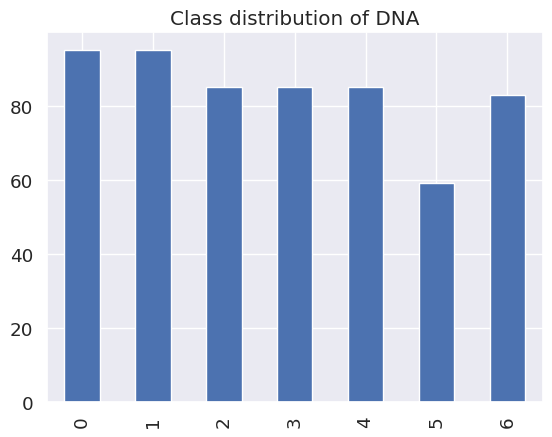

In [54]:
dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of DNA")

In [165]:
from Bio.Seq import Seq

# Função para calcular o reverso complemento
def calcular_reverso_complemento(sequence):
    seq = Seq(sequence)
    return str(seq.reverse_complement())
dna_rev = pd.DataFrame()
# Aplicar a função à coluna 'Sequencia' do DataFrame
dna_rev['sequence'] = dna['sequence'].apply(calcular_reverso_complemento)
dna_rev['class'] = dna['class']

In [167]:
dna = pd.concat([dna, dna_rev], axis=0)

In [168]:
def Kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

#convert our training data sequences into short overlapping k-mers of length 6.
#Lets do that for each species of data we have using our Kmers_funct function.

dna['words'] = dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
dna = dna.drop('sequence', axis=1)

In [169]:
dna.head()

,class,words
0,0,"[cgacag, gacaga, acagaa, cagaaa, agaaat, gaaat..."
1,0,"[cgacag, gacaga, acagaa, cagaaa, agaaat, gaaat..."
2,0,"[cgacag, gacaga, acagaa, cagaaa, agaaat, gaaat..."
3,0,"[cgacag, gacaga, acagaa, cagaaa, agaaat, gaaat..."
4,0,"[cgacag, gacaga, acagaa, cagaaa, agaaat, gaaat..."


In [170]:
dna_texts = list(dna['words'])
for item in range(len(dna_texts)):
    dna_texts[item] = ' '.join(dna_texts[item])
#separate labels
y_dna = dna.iloc[:, 0].values

In [171]:
y_dna

array([0, 0, 0, ..., 6, 6, 6])

In [172]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
X = cv.fit_transform(dna_texts)

In [173]:
print(X.shape)

(1174, 4886)


In [174]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_dna,
                                                    test_size = 0.20,
                                                    random_state=42)

In [175]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [176]:
y_pred = classifier.predict(X_test)

In [177]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000


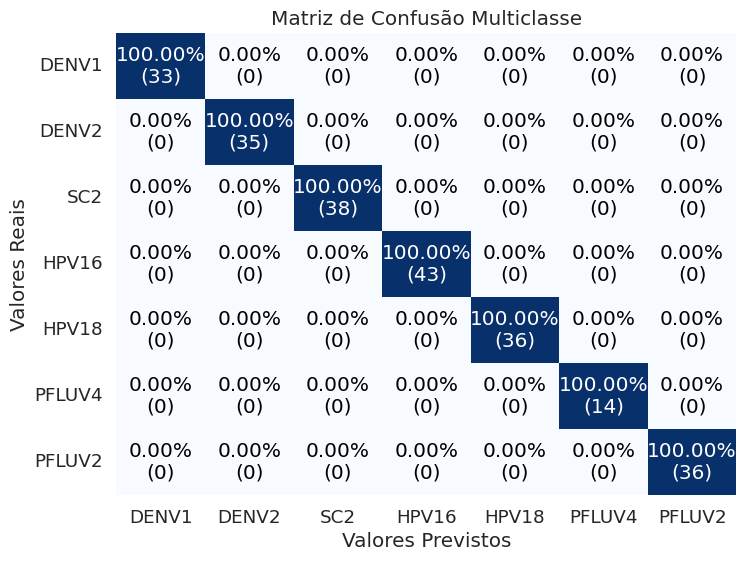

In [178]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def escolher_cor(valor):
  if valor >= 0.7:
    return "white"
  else:
    return "black"

labels = ["DENV1", "DENV2", "SC2", "HPV16", "HPV18", "PFLUV4", "PFLUV2"]

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)

# Configuração do gráfico
class_names = labels
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2%}\n({conf_matrix[i, j]})", ha="center", va="center", color=escolher_cor(conf_matrix_percent[i, j]))

plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão Multiclasse')
plt.show()

In [179]:
import joblib

# Salvando o modelo
joblib.dump(classifier, '/content/modelo_NLPV.joblib')

# Salvando o CountVectorizer
joblib.dump(cv, 'vectorizer.pkl')

['vectorizer.pkl']

In [216]:
# Abrindo o arquivo .fastq.gz

import pandas as pd
import gzip

def parse_fastq_gz(file_path):
    sequences = []
    with gzip.open(file_path, 'rt') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 4):
            header = lines[i].strip()
            sequence = lines[i + 1].strip()
            # Você pode querer adicionar tratamento de qualidade (linha 3) aqui, se necessário
            sequences.append(sequence)

    df = pd.DataFrame({'sequence': sequences})
    return df

# Substitua 'seu_arquivo.fastq.gz' pelo caminho do seu arquivo FASTQ comprimido
file_path = '/content/NLPV_input_HPV16.R1.fq.gz'
df = parse_fastq_gz(file_path)

# Agora, 'df' contém os nucleotídeos como um DataFrame do Pandas
print(df)


                                              sequence
0    TGTGCAACAACTTAGTGGTGTGGCAGGGGTTTCCGGTGTCTGGCTC...
1    AAAATATTAGGCAGCACTTGGCCAACCACTCCGCCGCGACCCATAC...
2    AAATTATTAGGCAGCACTTGGCCAACCACTCCGCCGCGACCCATAC...
3    AAATTATTAGGCAGCACTTGGCCAACCACTCCGCCGCGACCCATAC...
4    TGTGCAACAACTTAGTGGTGTGGCAGGGGTTTCCGGTGTCTGGCTC...
..                                                 ...
245  AAATTATTAGGCAGCACTGGGCCAACCACTCCGCCGCGACCCATAC...
246  AAATTATTAGGCAGCACTTGGCCAACCACTCCGCCGCGACCCATAC...
247  AAATTATTAGGCAGCACTTGGCCAACCACTCCGCCGCGACCCATAC...
248  AAATTATTAGGCAGCACTTGGCCAACCACTCCGCCGCGACCCATAC...
249  TGTGCAACAACTTAGTGGTGTGGCAGGGGTTTCCGGTGTCTGGCTC...

[250 rows x 1 columns]


In [217]:
df.head()

,sequence
0,TGTGCAACAACTTAGTGGTGTGGCAGGGGTTTCCGGTGTCTGGCTC...
1,AAAATATTAGGCAGCACTTGGCCAACCACTCCGCCGCGACCCATAC...
2,AAATTATTAGGCAGCACTTGGCCAACCACTCCGCCGCGACCCATAC...
3,AAATTATTAGGCAGCACTTGGCCAACCACTCCGCCGCGACCCATAC...
4,TGTGCAACAACTTAGTGGTGTGGCAGGGGTTTCCGGTGTCTGGCTC...


In [218]:
df['words'] = df.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
df = df.drop('sequence', axis=1)

In [219]:
print(df['words'])


0      [tgtgca, gtgcaa, tgcaac, gcaaca, caacaa, aacaa...
1      [aaaata, aaatat, aatatt, atatta, tattag, attag...
2      [aaatta, aattat, attatt, ttatta, tattag, attag...
3      [aaatta, aattat, attatt, ttatta, tattag, attag...
4      [tgtgca, gtgcaa, tgcaac, gcaaca, caacaa, aacaa...
                             ...                        
245    [aaatta, aattat, attatt, ttatta, tattag, attag...
246    [aaatta, aattat, attatt, ttatta, tattag, attag...
247    [aaatta, aattat, attatt, ttatta, tattag, attag...
248    [aaatta, aattat, attatt, ttatta, tattag, attag...
249    [tgtgca, gtgcaa, tgcaac, gcaaca, caacaa, aacaa...
Name: words, Length: 250, dtype: object


In [220]:
df_texts = list(df['words'])
for item in range(len(df_texts)):
    df_texts[item] = ' '.join(df_texts[item])

In [221]:
# load the model from disk
loaded_model = joblib.load("/content/modelo_NLPV.joblib")

# Para carregar o CountVectorizer posteriormente:
cv_saved = joblib.load('vectorizer.pkl')

In [222]:
X_df = cv_saved.transform(df_texts)

In [223]:
print(X_df.shape)

(250, 4886)


In [224]:
result = loaded_model.predict(X_df)
print(result)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [225]:
from collections import Counter
Counter(result)

Counter({3: 250})

([<matplotlib.axis.XTick at 0x7f830042df30>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

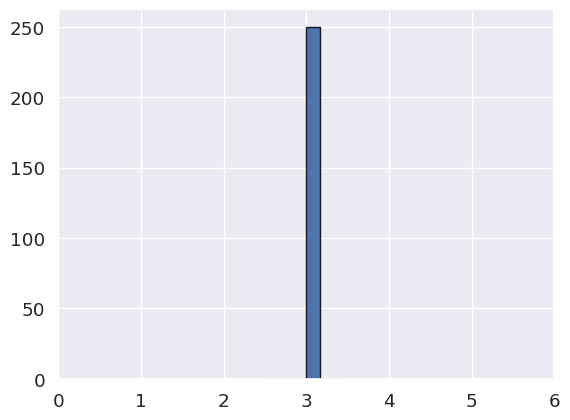

In [227]:
plt.hist(result, bins=6, edgecolor='k')
plt.xticks(np.arange(0, 7))